# Project: Customer Clusterization

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

# Data Preparation

In [3]:
df_raw = pd.read_csv("data.csv", low_memory=False)

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice       object
CustomerID     float64
Country         object
dtype: object

In [7]:
df1["Country"].value_counts().head()

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: Country, dtype: int64

In [8]:
# Since the UK is by far the most common country, we'll be working only with UK customers for now
df1 = df1.copy()[df1["Country"] == "United Kingdom"]

In [9]:
# Filtering any order without a customer ID
df1 = df1.dropna(axis="index", subset=["CustomerID"])

In [10]:
df1.loc[df1["Quantity"] < 0 , "StockCode"].value_counts()

22423     148
M         134
D          74
22960      69
22720      60
         ... 
21248       1
85049E      1
21206       1
85199L      1
23843       1
Name: StockCode, Length: 1756, dtype: int64

There appear to be three cases where the quantity is negative: The stock code is "D" indicating a discount, "M" possibly indicating a manual change, and a sequence of numbers, representing a returned product or cancelled purchase. Such entries also seem to have an invoice number starting with "C".

For the purposes of this customer fidelity clusterization project, the former two will be ignored when counting the total number of purchases, while returns will be subtracted. The monetary value of all transactions will be added, negative or positive.

In [11]:
# Drop columns that won't be used in this analysis.
df1 = df1.drop(columns=["Description", "Country"])

In [12]:
df1["InvoiceDate"] = df1["InvoiceDate"].astype("datetime64")
df1["UnitPrice"] = df1["UnitPrice"].str.replace(pat=",", repl="") # Remove the thousands separator
df1["UnitPrice"] = df1["UnitPrice"].astype(float)
df1["CustomerID"] = df1["CustomerID"].astype(int)

In [13]:
df1.dtypes

InvoiceNo              object
StockCode              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
dtype: object

# Exploratory Data Analysis

In [14]:
df1.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


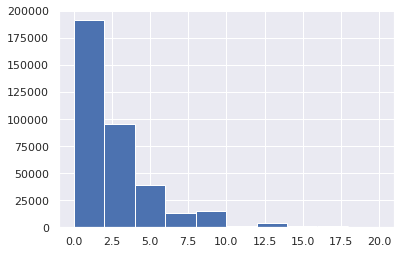

In [15]:
plt.hist(df1["UnitPrice"][ df1["UnitPrice"] < 20 ]);

In [16]:
count1 = df1["InvoiceNo"][df1["UnitPrice"] < 20].count()
count2 = df1["InvoiceNo"].count()
print(f"{count1} out of {count2} purchases were under $20, or {count1/count2:.2%} of the total.")

361028 out of 361878 purchases were under $20, or 99.77% of the total.


The vast majority of the purchases made on this database were of small value, as seen on the histogram.

In [17]:
df1["CustomerID"].value_counts().median()

41.0

In [18]:
count1 = (df1["CustomerID"].value_counts()>50).sum()
count2 = df1["CustomerID"].nunique()
print(f"{count1} out of {count2} customers made more than 50 purchases, or {count1/count2:.2%} of the total.")

1732 out of 3950 customers made more than 50 purchases, or 43.85% of the total.


In contrast, there's a a more even distribution of number of purchases, with many customers having made over 50 purchases in total.

# Feature Engineering

We'll create a new dataframe where each row represents a customer.

In [19]:
df2 = pd.DataFrame(df1["CustomerID"].unique(), columns=["CustomerID"])

The first feature we'll introduce is the *Total Revenue*, the sum of all the purchases the customer made so far. 

In [20]:
# First, we sum the amount of money spent on each purchase
df1["Subtotal"] = df1["Quantity"] * df1["UnitPrice"]
# Then we group the purchases from each customer and add it to the customer dataframe
aux = df1[["CustomerID", "Subtotal"]].groupby("CustomerID").sum().reset_index()
aux.columns=["CustomerID","TotalRevenue"]
if "TotalRevenue" in df2.columns:
    df2 = df2.drop(columns=["TotalRevenue"]) # In case there's already a column with that name, to avoid duplocation
df2 = pd.merge(df2, aux, on="CustomerID", how="left")

Another feature will be *Recency*, that is, the time since the last purchase.

In [21]:
# First, we'll use the last invoice date as the current time
curr_time = df1["InvoiceDate"].max()
df1["Recency"] = (curr_time - df1["InvoiceDate"]).dt.days
# Then the data for each customer is added to the dataframe
# We're only counting purchases, that is, transaction with value above zero
aux = df1[["Recency", "CustomerID"]][df1["Quantity"] > 0].groupby("CustomerID").min().reset_index()
if "Recency" in df2.columns:
    df2 = df2.drop(columns=["Recency"]) # In case there's already a column with that name, to avoid duplocation
df2 = pd.merge(df2, aux, on="CustomerID", how="left")

Finally, *Frequency* will be the total amount of purchases the customer made during the recorded period.

In [22]:
# We'll get the number of purchases, and subtract the number of returns
aux1 = df1[["CustomerID", "InvoiceNo"]][df1["Quantity"] > 0].groupby("CustomerID").nunique()
aux2 = df1[["CustomerID", "InvoiceNo"]][(df1["StockCode"].str.isdigit()) & (df1["Quantity"] < 0)].groupby("CustomerID").nunique()
aux = aux1.sub(aux2, fill_value=0)
aux = aux.reset_index()
aux.columns = ["CustomerID", "Frequency"]
if "Frequency" in df2.columns:
    df2 = df2.drop(columns=["Frequency"]) # In case there's already a column with that name, to avoid duplocation
df2 = pd.merge(df2, aux, on="CustomerID", how="left")

We will use those features for now. The shape of the data can be visualized, so that we can see if it needs to be scaled or remapped.

In [71]:
#Removing row with invalid data
df2 = df2.dropna(axis="index")
#Picks only customers with positive revenue and frequency
df2 = df2[df2["TotalRevenue"].gt(0) & df2["Frequency"].gt(0)]

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

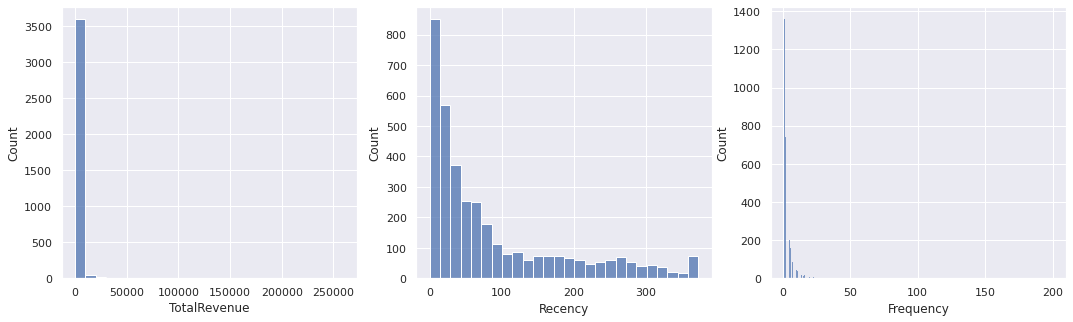

In [72]:
fig, ax = plt.subplots(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
sns.histplot(df2["TotalRevenue"], binwidth=10000, ax=ax1)
ax2 = plt.subplot(1,3,2)
sns.histplot(df2["Recency"], ax=ax2)
ax3 = plt.subplot(1,3,3)
sns.histplot(df2["Frequency"], ax=ax3)

Since the Total Revenue and Frequency metrics seem very concentrated on low values, so we'll try using the natural logarithm of the data.

In [79]:
df2["TotalRevenue"] = np.log(df2["TotalRevenue"])
df2["Frequency"] = np.log(df2["Frequency"])

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

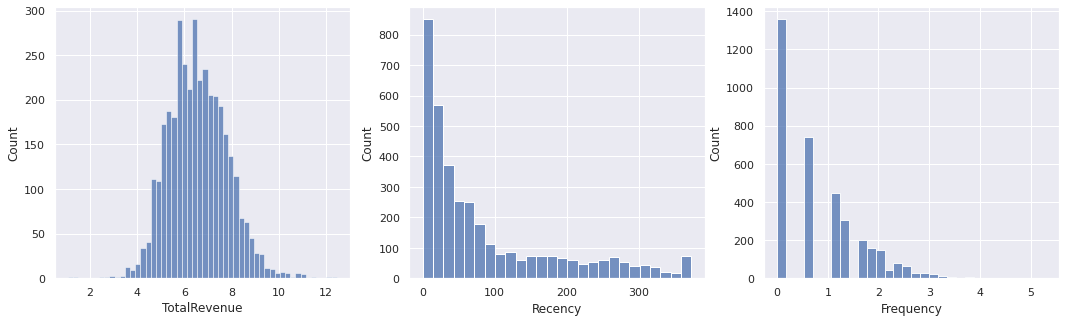

In [81]:
fig, ax = plt.subplots(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
sns.histplot(df2["TotalRevenue"], ax=ax1)
ax2 = plt.subplot(1,3,2)
sns.histplot(df2["Recency"], ax=ax2)
ax3 = plt.subplot(1,3,3)
sns.histplot(df2["Frequency"], ax=ax3)

In [73]:
df2.describe()

,CustomerID,TotalRevenue,Recency,Frequency
count,3675.000000,3675.000000,3675.000000,3675.000000
mean,15576.952925,1804.197505,87.288163,3.768435
std,1572.195678,6776.994063,97.507363,6.308481
min,12747.000000,2.900000,0.000000,1.000000
25%,14219.500000,297.535000,16.000000,1.000000
50%,15589.000000,657.230000,45.000000,2.000000
75%,16928.500000,1621.330000,130.500000,4.000000
max,18287.000000,256438.490000,373.000000,200.000000


In [70]:
df2

,CustomerID,TotalRevenue,Recency,Frequency
0,17850,5288.63,371.0,33.0
1,13047,3079.10,31.0,3.0
2,13748,948.25,95.0,5.0
3,15100,635.10,333.0,0.0
4,15291,4596.51,25.0,11.0
...,...,...,...,...
3945,15471,469.48,1.0,1.0
3946,13436,196.89,1.0,1.0
3947,15520,343.50,1.0,1.0
3948,13298,360.00,0.0,1.0


In [26]:
df2["TotalRevenue"].sort_values(ascending=False)

418     256438.49
372     187482.17
14       88125.38
804      65892.08
34       62653.10
          ...    
153       -840.76
1784     -1165.30
198      -1192.20
2805     -1592.49
2803     -4287.63
Name: TotalRevenue, Length: 3950, dtype: float64

In [27]:
df2.iloc[2803]

CustomerID      17448.00
TotalRevenue    -4287.63
Recency              NaN
Frequency            NaN
Name: 2803, dtype: float64

In [28]:
df2.iloc[392]

CustomerID      14673.0
TotalRevenue     1736.4
Recency             2.0
Frequency           5.0
Name: 392, dtype: float64

In [29]:
df2[df2["Recency"].isna()]

,CustomerID,TotalRevenue,Recency,Frequency
146,17547,-11.80,NaN,-1.0
171,13958,-102.45,NaN,-1.0
173,16995,-1.25,NaN,-1.0
198,14213,-1192.20,NaN,-1.0
200,14679,-2.55,NaN,-1.0
356,16138,-7.95,NaN,-1.0
476,12870,-14.90,NaN,-1.0
497,16252,-295.09,NaN,-1.0
551,16579,-30.60,NaN,NaN
557,17307,-152.64,NaN,-1.0


<AxesSubplot:xlabel='TotalRevenue', ylabel='Count'>

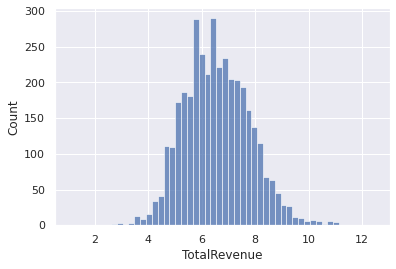

In [74]:
sns.histplot(np.log(df2["TotalRevenue"]))

In [76]:
np.log(657)

6.48768401848461

In [75]:
np.log?

Call signature:  np.log(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'log'>
File:            ~/anaconda3/lib/python3.9/site-packages/numpy/__init__.py
Docstring:      
log(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Natural logarithm, element-wise.

The natural logarithm `log` is the inverse of the exponential function,
so that `log(exp(x)) = x`. The natural logarithm is logarithm in base
`e`.

Parameters
----------
x : array_like
    Input value.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must have length equal to the number of outputs.
where : array_like, optional
    This condition is broadcast over the input. At locations where the
    condition is True

In [31]:
df1[(df1["InvoiceNo"].str.match("C")) & (df1["Quantity"] < 0)]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Subtotal,Recency
141,C536379,D,-1,2010-12-01 09:41:00,27.50,14527,-27.50,373
154,C536383,35004C,-1,2010-12-01 09:49:00,4.65,15311,-4.65,373
235,C536391,22556,-12,2010-12-01 10:24:00,1.65,17548,-19.80,373
236,C536391,21984,-24,2010-12-01 10:24:00,0.29,17548,-6.96,373
237,C536391,21983,-24,2010-12-01 10:24:00,0.29,17548,-6.96,373
...,...,...,...,...,...,...,...,...
540449,C581490,23144,-11,2011-12-09 09:57:00,0.83,14397,-9.13,0
541541,C581499,M,-1,2011-12-09 10:28:00,224.69,15498,-224.69,0
541715,C581568,21258,-5,2011-12-09 11:57:00,10.95,15311,-54.75,0
541716,C581569,84978,-1,2011-12-09 11:58:00,1.25,17315,-1.25,0


In [32]:
a = pd.Series([1,0,3] , index=["a","b","c"])
b = pd.Series([3,4,5], index=["b","a","c"])

In [33]:
a+b

a    5
b    3
c    8
dtype: int64

In [34]:
df1[["CustomerID", "InvoiceNo"]].groupby("CustomerID").nunique()

,InvoiceNo
CustomerID,
12346,2
12747,11
12748,224
12749,8
12820,4
...,...
18280,1
18281,1
18282,3


In [35]:
aux

,CustomerID,Frequency
0,12346,0.0
1,12747,11.0
2,12748,200.0
3,12749,2.0
4,12820,4.0
...,...,...
3939,18280,1.0
3940,18281,1.0
3941,18282,1.0
3942,18283,16.0


In [36]:
aux1

,InvoiceNo
CustomerID,
12346,1
12747,11
12748,210
12749,5
12820,4
...,...
18280,1
18281,1
18282,2
